In [154]:
import pandas as pd
import numpy as np
from datetime import datetime
import matplotlib.pyplot as plt
import regex as re
import math
from collections import defaultdict
import pytz
import shin

from scipy.stats import norm
from scipy.optimize import brentq
from scipy.special import expit, logit

from rapidfuzz.fuzz import ratio

Done:
- Created pregame df
- Created pregame to end of game df
- Created edge_df
- Created filtered_df (no duplicates)
To Do:
- Test the probability that given starting probability X, the market reaches probability Y (at any point during game)
- Adjust testing process for new dataframes (date specific)
- Use all markets to test probability of hitting tp/sl (means we need tp/sl for all markets, not just positive ev trades)

In [155]:
start_date = '2026-01-30'
end_date = '2026-02-05'
sport = 'NBA' #NCAAMB, NCAAWB, NBA, ATP, WTA, MLB
market = "GAME" #GAME, SPREAD, TOTAL

if sport == 'ATP' or sport == 'WTA':
    market = 'MATCH'

date_range = pd.date_range(start=start_date, end=end_date, freq='D')

In [156]:
#betus good for nba, pinnacle, betonline best for everything, fanduel pretty good
df_dict = {}
pregame_df_dict = {}

for date in date_range:
    date_str = date.strftime('%Y-%m-%d')
    df = pd.read_csv(f"../data_collection/kalshi_data/kalshi_logs/{date_str}/joined_{date_str}.csv")

    df = df[df['match_status'] == 'matched']
    df = df[df['ticker'].str.startswith(f"KX{sport}{market}", na=False)]
    if df.empty:
        continue

    df['fetch_dt'] = pd.to_datetime(df['oddsapi_fetch_timestamp'], errors='coerce')
    # Parse oddsapi_start_time: strip timezone suffix (CST/CDT) then localize (format %Z fails on many platforms)
    _start_str = df['oddsapi_start_time'].astype(str).str.replace(r'\s+[A-Z]{3}$', '', regex=True)
    df['start_dt'] = pd.to_datetime(_start_str, format='%Y-%m-%d %H:%M:%S', errors='coerce').dt.tz_localize('America/Chicago', ambiguous='infer')
    df['kalshi_dt'] = pd.to_datetime(df['timestamp'], errors='coerce')

    gap = df['start_dt'] - df['fetch_dt']
    pregame_df = df[(gap >= pd.Timedelta(0)) & (gap <= pd.Timedelta(minutes=30))].copy()
    # Target: 10 min before game start; keep one row per ticker where timestamp is closest to that
    pregame_df['target_dt'] = pregame_df['start_dt'] - pd.Timedelta(minutes=5)
    pregame_df['dist'] = (pregame_df['kalshi_dt'] - pregame_df['target_dt']).abs()
    pregame_df = pregame_df.loc[pregame_df.groupby('ticker')['dist'].idxmin()]
    if pregame_df.empty:
        continue

    pregame_df = pregame_df.drop(columns=['fetch_dt', 'start_dt', 'kalshi_dt', 'target_dt', 'dist'])
    df_dict[date_str] = df.copy()
    pregame_df_dict[date_str] = pregame_df.copy()


/var/folders/dv/l04j1r_d2mgbb4ngbgfg__0r0000gn/T/ipykernel_34286/2273292412.py:7: DtypeWarning: Columns (15,16,18,19,20,21) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(f"../data_collection/kalshi_data/kalshi_logs/{date_str}/joined_{date_str}.csv")


In [157]:
# For each market in pregame_df, include the pregame row and all rows with timestamp >= that row's timestamp (pregame through end of game)
to_end_dict = {}
for date_str in pregame_df_dict.keys():
    pregame_starts = pregame_df_dict[date_str].set_index('ticker')['timestamp']
    df_dict[date_str]['_pregame_start'] = df_dict[date_str]['ticker'].map(pregame_starts)
    pregame_to_end_df = df_dict[date_str][df_dict[date_str]['ticker'].isin(pregame_starts.index) & (df_dict[date_str]['timestamp'] >= df_dict[date_str]['_pregame_start'])].drop(columns=['_pregame_start'])
    to_end_dict[date_str] = pregame_to_end_df.copy()

In [158]:
EDGE = 0.01
KELLY_UPPERBOUND = 1
BANKROLL = 1000.00
Q1_WEIGHT = 1.00
Q2_WEIGHT = 1.00
Q3_WEIGHT = 1.00
Q4_WEIGHT = 1.00

#midprice = (pregame_df['yes_bid'] + df['yes_ask']) / 2

edge_df_dict = {}

for date_str in pregame_df_dict.keys():
    edge_df = pregame_df_dict[date_str].loc[
        (pregame_df_dict[date_str]['devig_prob'] >= pregame_df_dict[date_str]['yes_ask'] + EDGE) | 
        ((1 - pregame_df_dict[date_str]['devig_prob']) >= pregame_df_dict[date_str]['no_ask'] + EDGE)
    ].reset_index(drop=True)

    #midprice = (edge_df['yes_bid'] + edge_df['yes_ask']) / 2
    #edge_df['midprice'] = midprice

    edge_df = edge_df.loc[((edge_df['devig_prob'] > 0.15) & (edge_df['devig_prob'] < 0.49)) |
                                      ((edge_df['devig_prob'] > 0.51) & (edge_df['devig_prob'] < 0.85)) ]

    #midprice_yes = (edge_df['yes_bid'] + edge_df['yes_ask']) / 2
    #midprice_no = (edge_df['no_bid'] + edge_df['no_ask']) / 2

    q_yes = edge_df['devig_prob']
    q_no = 1 - edge_df['devig_prob'] 

    #edge_winners_df['edge'] = np.where(q_yes > midprice_yes, q_yes - midprice_yes, q_no - midprice_no)
    edge_df['edge'] = np.where(q_yes > edge_df['yes_ask'], q_yes - edge_df['yes_ask'], q_no - edge_df['no_ask'])

    edge_df['bid'] = np.where(q_yes > edge_df['yes_ask'], edge_df['yes_bid'], edge_df['no_bid'])
    edge_df['ask'] = np.where(q_yes > edge_df['yes_ask'], edge_df['yes_ask'], edge_df['no_ask'])

    edge_df['buy_direction'] = np.where(edge_df['devig_prob'] > edge_df['yes_ask'], "yes", "no")
    edge_df.reset_index(drop=True, inplace=True)
    edge_df = edge_df.drop(columns = ['title', 'status', 'market_type', 'event_start_time', 'oddsapi_game_id', 'oddsapi_fetch_timestamp', 'oddsapi_start_time', 'oddsapi_home_team', 'oddsapi_away_team', 'match_status'])

    if (len(edge_df) == 0):
        continue

    edge_df_dict[date_str] = edge_df.copy()

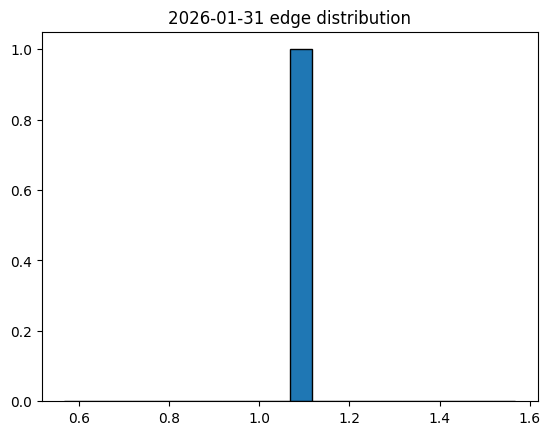

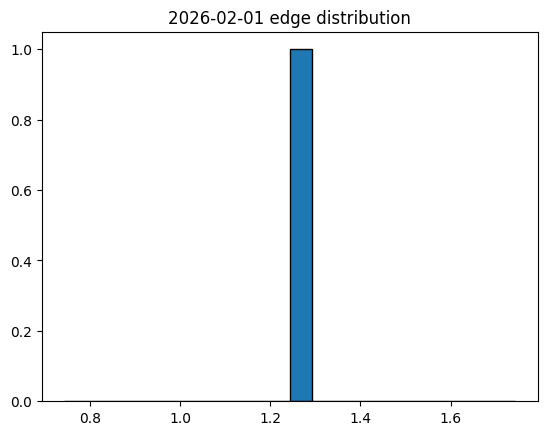

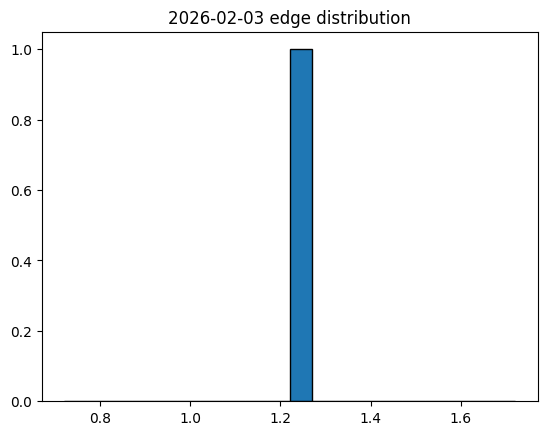

In [159]:
for date_str in edge_df_dict.keys():
    edge_df = edge_df_dict[date_str]
    plt.hist(edge_df['edge'] * 100, bins=20, edgecolor='black')
    plt.title(f"{date_str} edge distribution")
    plt.show()

In [160]:
def compute_hitting_prob(row, sl, tp):
    """ 
    Assuming biased or unbiased random walk based on the fraction of previous month's
    up / total step count 
    """
    if row['buy_direction'] == 'yes':
        prob = row['devig_prob']
    else:
        prob = 1 - row['devig_prob']
    rv = prob
    if (prob >= 0.4) & (prob <= 0.6):
        rv = (prob - sl) / (tp - sl)
        return rv
    elif (prob >=0.3) & (prob < 0.4):
        p = 0.35
        q = 0.65
    elif (prob >= 0.2) & (prob < 0.3):
        p = 0.3
        q = 0.7
    elif (prob >= 0.10) & (prob < 0.2):
        p = 0.25
        q = 0.75
    elif (prob > 0.6) & (prob <= 0.7):
        p = 0.65
        q = 0.35
    elif (prob > 0.7) & (prob <= 0.8):
        p = 0.7
        q = 0.3
    elif (prob > 0.8) & (prob <= 0.9):
        p = 0.75
        q = 0.25
    rv = (1 - ((q / p) ** (prob - sl))) / (1 - ((q / p) ** (tp - sl)))
    return rv

In [161]:
KELLY_FRAC = 0.25
ev_dict = {}

for date_str in edge_df_dict.keys():
    ev_dict_loc = defaultdict(list)
    edge_df = edge_df_dict[date_str]
    for i in range(len(edge_df)):
        row = edge_df.iloc[i]
        #entry = row['bid']
        entry = row['ask']
        tp_list = []
        sl_list = []
        if row['buy_direction'] == 'yes':
            effective_prob = row['devig_prob']
        else:
            effective_prob = 1 - row['devig_prob']
        temp_tp = effective_prob + 0.1
        temp_sl = entry - 0.1
        while (temp_tp < 1):
            tp_list.append(temp_tp)
            temp_tp = temp_tp + 0.01
        assert(len(tp_list) != 0)
        while (temp_sl > 0):
            sl_list.append(temp_sl)
            temp_sl = temp_sl - 0.01
        if len(sl_list) == 0:
            sl_list.append(0)
        for tp in tp_list:
            for sl in sl_list:
                if tp <= sl:
                    continue
                if not (sl < entry < tp):
                    continue
                if not (sl < effective_prob < tp):
                    continue
            
                p = compute_hitting_prob(row, sl, tp)
                #p = (row['devig_prob'] - sl) / (tp - sl)
                kelly = entry * (p * (tp - entry) - (1 - p) * (entry - sl)) / ((tp - entry) * (entry - sl))
                if kelly <= 0:
                    continue
                kelly = min(kelly * KELLY_FRAC, 0.1)
                optimal_bet = kelly * BANKROLL
                num_contracts = optimal_bet // entry
                trading_cost_entry = np.ceil(100*(0.0175 * num_contracts * entry * (1 - entry))) / 100
                trading_cost_exit1 = np.ceil(100*(0.0175 * num_contracts * tp * (1 - tp))) / 100
                trading_cost_exit2 = np.ceil(100*(0.0175 * num_contracts * sl * (1 - sl))) / 100
                trading_cost_exit = (trading_cost_exit1 + trading_cost_exit2) / 2
                trading_cost = trading_cost_entry + trading_cost_exit
                profit = num_contracts * (tp - entry)
                loss = num_contracts * (entry - sl)
                ev = profit * p - loss * (1 - p) - trading_cost
                ev_dict_loc[i].append([tp, sl, kelly, optimal_bet, num_contracts, trading_cost, profit, loss, ev, p])
        ev_dict[date_str] = ev_dict_loc.copy()
        


In [162]:
plot_date = "2026-02-05"
if plot_date in ev_dict.keys():
    plot_date_ev_dict =ev_dict[plot_date]

    #plots the ev distribution for every trade for different pairs of (tp, sl)
    for i, trade_curr in plot_date_ev_dict.items():
        tp_list, sl_list, _, _, _, _, _, _, ev_list, p_list = map(list, zip(*trade_curr))
        plt.hist(ev_list, bins=30, edgecolor='black')
        plt.title(f"ev distribution for trade {i} ({plot_date})")
        plt.show()
    

In [163]:
cols = ['tp', 'sl', 'kelly', 'optimal_bet', 'num_contracts', 'trading_cost', 'profit', 'loss', 'ev', 'p']

filtered_df_dict = {}

for date_str in ev_dict.keys():
    best_by_key = {
    k: max(trades, key=lambda x: x[8])   
    for k, trades in ev_dict[date_str].items()
    if trades
}

    best_by_key = {
        k: [round(v[0], 2), round(v[1], 2), *v[2:]]
        for k, v in best_by_key.items()
    }

    keys = list(best_by_key.keys())
    filtered_df = edge_df_dict[date_str].iloc[keys].copy()
    filtered_df[cols] = np.array([best_by_key[k] for k in keys], dtype=float)
    filtered_df = filtered_df.loc[filtered_df['ev'] > 0]
    filtered_df_dict[date_str] = filtered_df.copy()


In [164]:
# Select columns; use p_hit if p was already renamed (e.g. from re-running this cell)
select_cols = ['ticker', 'oddsapi_team', 'yes_ask','no_ask', 'ask', 'devig_prob', 'edge', 'buy_direction',
    'tp', 'sl', 'kelly', 'optimal_bet', 'num_contracts', 'trading_cost', 'profit', 'loss', 'ev']

for date_str in filtered_df_dict.keys():
    p_col = 'p' if 'p' in filtered_df_dict[date_str].columns else 'p_hit'
    if p_col in filtered_df_dict[date_str].columns:
        select_cols.insert(select_cols.index('sl') + 1, p_col)
    filtered_df_dict[date_str] = filtered_df_dict[date_str][[c for c in select_cols if c in filtered_df_dict[date_str].columns]]
    if 'p' in filtered_df_dict[date_str].columns:
        filtered_df_dict[date_str].rename(columns={"p": "p_hit"}, inplace=True)
    filtered_df_dict[date_str]['edge'] = filtered_df_dict[date_str]['edge'] * 100
    filtered_df_dict[date_str][['kelly', 'profit', 'ev', 'optimal_bet']] = filtered_df_dict[date_str][['kelly', 'profit', 'ev', 'optimal_bet']].round(2)
    filtered_df_dict[date_str][['devig_prob', 'p_hit']] = filtered_df_dict[date_str][['devig_prob', 'p_hit']].round(4) * 100

    filtered_df_dict[date_str]['market_key'] = filtered_df_dict[date_str]['ticker'].str.rsplit('-', n=1).str[0]
    idx_to_keep = filtered_df_dict[date_str].groupby('market_key')['ev'].idxmax()
    filtered_df_dict[date_str] = filtered_df_dict[date_str].loc[idx_to_keep].drop(columns=['market_key']).reset_index(drop=True)


    # s = filtered_df['oddsapi_start_time'].astype(str)
    # s = s.str.replace(r'\s+[A-Z]{3}$', '', regex=True)
    # dt = pd.to_datetime(s, errors='coerce')

    # now = datetime.now(pytz.timezone('America/Chicago'))
    #filtered_df = filtered_df.loc[filtered_df['oddsapi_start_time'] > now].sort_values('oddsapi_home_team').reset_index(drop=True)

In [165]:
trade_date = "2026-02-01"
filtered_df_dict[trade_date]

,ticker,oddsapi_team,yes_ask,no_ask,ask,devig_prob,edge,buy_direction,tp,sl,p_hit,p_hit,kelly,optimal_bet,num_contracts,trading_cost,profit,loss,ev
0,KXNBAGAME-26FEB01CHIMIA-CHI,Chicago Bulls,0.36,0.65,0.65,33.76,1.243427,no,0.99,0.01,72.92,72.92,0.06,56.67,87.0,0.37,29.79,55.68,6.28


In [166]:
total_loss = np.sum(filtered_df_dict[trade_date]['loss'])
total_profit = np.sum(filtered_df_dict[trade_date]['profit'])
total_ev = np.sum(filtered_df_dict[trade_date]['ev'])
print(f"{sport} h2h portfolio summary:\n")
print(f"Max Loss: -{total_loss:.2f}")
print(f"Max Profit: {total_profit:.2f}")
print(f"Portfolio EV: {total_ev:.2f}")


NBA h2h portfolio summary:

Max Loss: -55.68
Max Profit: 29.79
Portfolio EV: 6.28


In [167]:
#concatenate all pregame dfs
pg_list = []
for date_str, df in pregame_df_dict.items():
    df_copy = df.copy()
    df_copy['date'] = date_str
    pg_list.append(df_copy)

pregame_df_agg = pd.concat(pg_list, ignore_index=True)

In [168]:
#concatenate all pregame to end of game dfs
df_list = []
for date_str, df in to_end_dict.items():
    df_copy = df.copy()
    df_copy['date'] = date_str
    df_list.append(df_copy)

to_end_df_agg = pd.concat(df_list, ignore_index=True)


In [169]:
START_PROB = 0.50 #Yes_ask at game start

# Group markets by starting point, track probability of hitting for each percentage point
test_df = pregame_df_agg.loc[pregame_df_agg['yes_ask'] == START_PROB]
test_df

,timestamp,ticker,title,status,market_type,event_start_time,yes_bid,yes_ask,no_bid,no_ask,...,devig_prob,oddsapi_game_id,oddsapi_team,oddsapi_point,oddsapi_home_team,oddsapi_away_team,oddsapi_start_time,oddsapi_fetch_timestamp,match_status,date
40,2026-02-02T22:05:00.167484-05:00,KXNBAGAME-26FEB02PHILAC-LAC,Philadelphia at Los Angeles C Winner?,active,binary,NaN,0.49,0.5,0.5,0.51,...,0.482909,93838984e2cd0b0796d8bab2c603ae55,Los Angeles Clippers,NaN,Los Angeles Clippers,Philadelphia 76ers,2026-02-02 21:10:00 CST,2026-02-02T20:50:28.942084-06:00,matched,2026-02-02


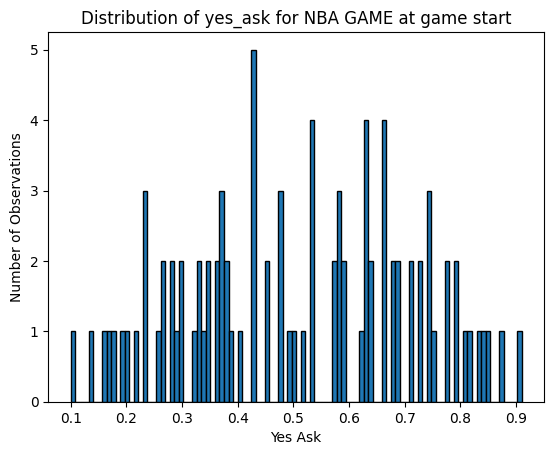

In [170]:
#Check number of observations for each starting value
pregame_df_agg['yes_ask'].value_counts()

plt.hist(pregame_df_agg['yes_ask'], bins=100, edgecolor='black')
plt.title(f"Distribution of yes_ask for {sport} {market} at game start")
plt.xlabel("Yes Ask")
plt.ylabel("Number of Observations")
plt.show()


